# Анализ оттока клиентов фитнес-центра
<div style="border:solid green 2px; padding: 20px">

<b>Закачик</b> - Сеть фитнес-центров "Культурист-датасаентист"
    
<b>Описание исследования:</b>

<b>Цель</b> - Проанализировать базу клиентов фитнес-центров сети с целью формирования плана действий по их удержанию в числе пользователей услуг. 
    
<b>Задачи исследования:</b> 
- Спрогнозировать вероятность оттока для каждого клиента (на уровне следующего месяца).
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства.
- Проанализировать основные признаки, в большей степени влияющие на отток.
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами, а именно:
    > - 1) выделить целевые группы клиентов;
    > - 2) предложить меры по снижению оттока;
    > - 3) определить другие особенности взаимодействия с клиентами.
    
<b>Данные</b> - Для исследования взяты следующие данные:

_Таблица **gym_churn** (содержит данные на месяц до оттока и факт оттока на определённый месяц):_

- Данные клиента за предыдущий до проверки факта оттока месяц:
    > - 'gender' — пол;
    > - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    > - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    > - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    > - 'Phone' — наличие контактного телефона;
    > - 'Age' — возраст;
    > - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    > - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    > - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    > - 'Group_visits' — факт посещения групповых занятий;
    > - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    > - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    > - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

In [1]:
# импортирую все библиотеки, которые могут понадобиться в ходе исследования
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
from math import factorial
import statsmodels.api as sm 
import plotly.express as px 
from plotly import graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# отключаю системные предупреждения
import warnings
warnings.filterwarnings('ignore')

In [3]:
# помощь в отображении данных
pd.set_option('display.max_columns', None) # отображение всех столбцов
pd.set_option('display.max_colwidth', None) # отображение данных в столбцах, даже если они слишком длинные
pd.set_option("display.float_format", "{:.2f}".format) # избавляюсь от экспоненциальной записи

In [4]:
# загружаю исследуемые таблицы
# использую try / except для оптимизации перехода с работы на платформе на локальный режим
try:
    gym_df = pd.read_csv('/datasets/gym_churn.csv')

except:
    gym_df = pd.read_csv('../Ksenia/Downloads/telecom_clients.csv')

## Знакомство с данными и предобработка

In [5]:
# немного упрощу себе работу по знакомству с данными, объявлю функцию, которая будет выдавать нужную мне информацию
def show_info(df):
    print('\033[1m' + 'Первые 5 строк датафрейма' + '\033[0m')
    display(df.head())
    print('\033[1m' + 'Информация о датафрейме' + '\033[0m')
    display(df.info())
    print('\033[1m' + 'Названия столбцов датафрейма' + '\033[0m')
    display(df.columns)
    print('\033[1m' + 'Информация о пропусках в датафрейме' + '\033[0m')
    display(df.isna().sum())
    print('\033[1m' + 'Уникальные значения' + '\033[0m')
    display(df.nunique())
    print('\033[1m' + 'Явные дубликаты в датафрейме' + '\033[0m')
    display(df.duplicated().sum())  


In [6]:
show_info(gym_df)

Первые 5 строк датафрейма


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total       

None

Названия столбцов датафрейма


Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

Информация о пропусках в датафрейме


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Уникальные значения


gender                                  2
Near_Location                           2
Partner                                 2
Promo_friends                           2
Phone                                   2
Contract_period                         3
Group_visits                            2
Age                                    23
Avg_additional_charges_total         4000
Month_to_end_contract                  12
Lifetime                               29
Avg_class_frequency_total            3913
Avg_class_frequency_current_month    3820
Churn                                   2
dtype: int64

Явные дубликаты в датафрейме


0

<div style="border:solid black 1px; padding: 20px">
    
**Предварительный вывод о данных**:
- в датафрейме 4000 строк
- в датафрейме 14 столбцов
- отсутствуют пропуски (если бы у меня была возможность, я бы подлагодарила того, кто собирал эту базу)
- в датафрейме нет явных дубликатов
- число уникальных значений пока не вызывает вопросов (2 пола, 3 типа контрактов (месяц, 6 месяцев, год), и т.д.)

---
_Замечания:_

- приведу названия столбцов к нижнему регистру

In [7]:
gym_df.columns = gym_df.columns.str.lower()
gym_df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Замечания к датафрейму устранены, он готов к дальнейшей работе.

## Исследовательский анализ данных (EDA)

### Описательная статистика
Ранее я уже провела проверку на отсутсвующие значения. Пропуски обнаружены не были. Однако стоит изучить датафрейм с точки зрения описательной статистики. Эту задачу решу при помощи метода `describe()`.

In [8]:
gym_df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


<div style="border:solid black 1px; padding: 20px">

**Интересные наблюдения:**
- Среди клиентов наблюдается примерно равное распределение полов
- 85% клиентов выбирают центр по близости к месту работы или месту жительства
- Примерно половина клиентов является сотрудниками партнеров клуба, то есть посещают его со скидкой
- 31% клиентов пришли в рамках акции "Приведи друга"
- 90% посетителей оставили свой контактный телефон
- Средний срок абонемента 4,7 месяца, при этоим медианное значение составляет 1 месяц. Это обусловленно начиличием достаточного числа клиентов, приобретающих абонемент на год
- 41% клиентов посещает групповые занятия
- Средний возраст клиентов фитнес-центров составляет 29 лет, что соответвует и медианному значению. Самый "взрослый клиент" - 41 год
- Среднее значение времени, через которое закрывают контракт - 4,7 месяцев, что соответвует стреднему сроку абонемента
- Средний "возраст" клиента - 3,7 месяца. Медианный "возраст" - 3 месяца. Самый долгопосещающий фитнес-центр клиент занимается 31 месяц (2,6 лет)
- В среднем клиенты посещают центр 1-2 раза в неделю. Самое частое посещение - 6 раз в неделю (мне бы их силу воли)
- В среднем отток клиентов составляет 27%


### Среднее значение признаков в группах действующих и ушедших клиентов

In [9]:
gym_df.groupby('churn').mean().T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


<div style="border:solid black 1px; padding: 20px">

**Интересные наблюдения:**
- Распределение по половой принадлежности среди действующих и ушедших клиентов практически равно. _Перекосов с пользу какого-либо пола не обнаружено_


- Среди тех клиентов, кто остался, 87% живут или работают рядом. Среди клиентов, прекративших посещенние, 77% живут или работают рядом. Столь высокий _процент не позволяет наверняка сказать, что территориальная принадлежность клиента влияет на то уйдет он или останется_


- Среди оставшихся клиентов 53% имеют скидку по партнерской программе. Среди тех кто ушел этот показатель составляет 37%. _С натяжкой можно сказать, что начилие скидки на услуги может повлиять на то, что клиент продолжит посещять клуб и продлит абонемент_


- Среди тех кто остался 35% привели в клуб друзья. Для тех кто перестал посещать центр этот показатель составляет 11%. _Наблюдается зависимость - если клиент посещает центр с другом, есть вероятность, что он продлит абонемент_


- Как среди действующит, так и среди покинувших центр клиентов, 90% оставляют телефон. _Наличие контактного телефона не влияет на отток_


- Клиенты которые остались в среднем имеют абонемент продолжительностью 6 месяцев. _Среди ушедших клиентов этот показатель равен 1,7. Можно заметить, что клиент, приобретающих краткосрочный абонемент не станет его продлевать_


- Среди действующих клиентов 46% посещают групповые занятия. Среди клиентов попавших в отток этот показатель составлет 27%. Можно зафиксировать, что _клиенты, посещающие групповые занятия с меньшей вероятностью перестанут посещать фитнес-центр_


- Среди действующих клиентов средний возраст составляет проимерно 30 лет. Среди тех кто перестал посещать центр этот показатель составляет 27 лет (возможно их метаболизм еще в порядке). _Наверняка зафиксировать влияние возраста на отток нельзя_


- Днействующие клиенты имеют показатель выручки на другие услуги центра на уровне 158,5. У клиентов, попавших в отток, этот показатель равен 115. _Возможно, чем больше тратит клиент, тем меньше вероятность, что он перестанет посещать клуб_


- Срок до окончания абонемента у текущих клиентов на уроверне примерно 5,3 месяцев. У клиентов в оттоке этот показатель на уровне 1,6. Снова можно заметить, что _чем меньше срок абонемента, тем выше вероятность, что клиент перестанет посещать центр_


- Текущие клиенты посещют клуб примерно 2 раза в неделю. Клиенты в оттоке посещают клуб примерно 1 раз в неделю. _Можно предположить, что чем реже клиент посещает клуб, тем выше вероятность, что он не станет продлевать абонемент_

### Построение столбчатых гистограмм и распределение признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

<div style="border:solid black 1px; padding: 20px">

В первую очередь распределю признаки в таблице на числовые и категориальные. Это необходимо для того, чтобы определиться для каких показателей, какие графики будут построены.

**Числовые**
- age — возраст
- month_to_end_contrac — срок до окончания текущего действующего абонемента (в месяцах)
- lifetime - время с момента первого обращения в фитнес-центр (в месяцах)
- avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента
- avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон
- avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц

**Категориальные**
- gender — пол
- near_location — проживание или работа в районе, где находится фитнес-центр
- partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- phone — наличие контактного телефона
- contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год)
- group_visits — факт посещения групповых занятий
- churn — факт оттока в текущем месяце


Определившись с распределением признаков, можно приступить к построению гистограмм распределения.

Для того чтобы в графиках можено было отобразить "красивые" названия, задам каждому из параметров русифицированный вариант.

In [10]:
# русифицированные наименования
argument_rus = ['Пол', 'Фитнес центр рядом с работой или местом жительства', 'Сотрудник компании-партнера клуба', 
                'Пришел по акции "приведи друга"', 'Телефон', 'Длительность текущего абонемента, в месяцах', 
                'Посещал групповые занятия', 'Возраст','Cуммарная выручка от других услуг фитнес-центра', 
                'Срок до окончания текущего абонемента, в месяцах','Время с момента первого обращения в фитнес-центр, в месяцах',
                'Средняя частота посещений в неделю за все время с начала действия абонемента',
                'Средняя частота посещений в неделю за предыдущий месяц']

# наименование столбцов анализируемого датафрейма
argument_eng = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age',
                'avg_additional_charges_total','month_to_end_contract','lifetime','avg_class_frequency_total',
                'avg_class_frequency_current_month']

# тип переменной
kind = ['category', 'category', 'category', 'category', 'category', 'number', 
        'category', 'number', 'number', 'number', 'number', 'number', 'number']

# создание датафрейма, где каждому параметру соответствует руссифицированный аналог и его тип
argument_name = pd.DataFrame({'name': argument_eng, 'rus_name': argument_rus, 'type': kind})

argument_name

,name,rus_name,type
0,gender,Пол,category
1,near_location,Фитнес центр рядом с работой или местом жительства,category
2,partner,Сотрудник компании-партнера клуба,category
3,promo_friends,"Пришел по акции ""приведи друга""",category
4,phone,Телефон,category
5,contract_period,"Длительность текущего абонемента, в месяцах",number
6,group_visits,Посещал групповые занятия,category
7,age,Возраст,number
8,avg_additional_charges_total,Cуммарная выручка от других услуг фитнес-центра,number
9,month_to_end_contract,"Срок до окончания текущего абонемента, в месяцах",number


In [11]:
d_feature_mapping = {}
for feature, name, type_ in zip(argument_eng, argument_rus, kind):
    d_feature_mapping[feature] = {"name": name, "type": type_}
    
d_feature_mapping

{'gender': {'name': 'Пол', 'type': 'category'},
 'near_location': {'name': 'Фитнес центр рядом с работой или местом жительства',
  'type': 'category'},
 'partner': {'name': 'Сотрудник компании-партнера клуба', 'type': 'category'},
 'promo_friends': {'name': 'Пришел по акции "приведи друга"',
  'type': 'category'},
 'phone': {'name': 'Телефон', 'type': 'category'},
 'contract_period': {'name': 'Длительность текущего абонемента, в месяцах',
  'type': 'number'},
 'group_visits': {'name': 'Посещал групповые занятия', 'type': 'category'},
 'age': {'name': 'Возраст', 'type': 'number'},
 'avg_additional_charges_total': {'name': 'Cуммарная выручка от других услуг фитнес-центра',
  'type': 'number'},
 'month_to_end_contract': {'name': 'Срок до окончания текущего абонемента, в месяцах',
  'type': 'number'},
 'lifetime': {'name': 'Время с момента первого обращения в фитнес-центр, в месяцах',
  'type': 'number'},
 'avg_class_frequency_total': {'name': 'Средняя частота посещений в неделю за все вре

Отлично, теперь можно приступить к построению гистограмм. Чтобы упростить себе работу, выполню эту задачу задав функцию.

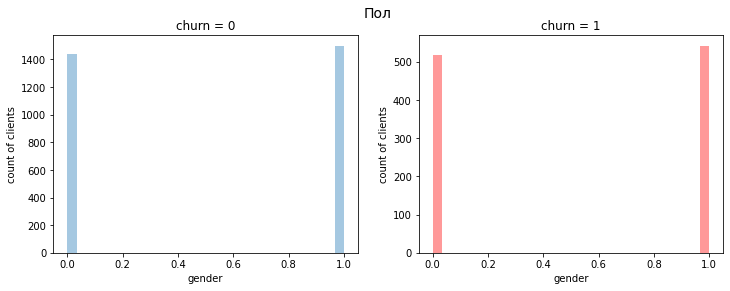

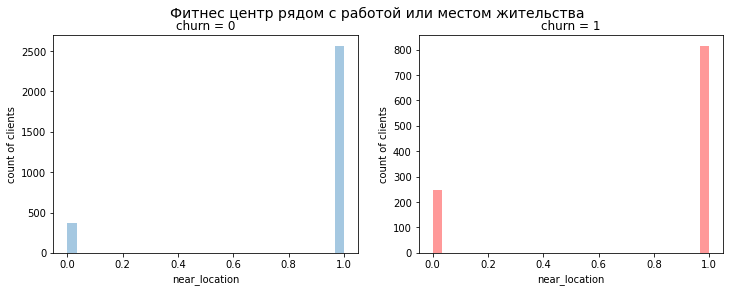

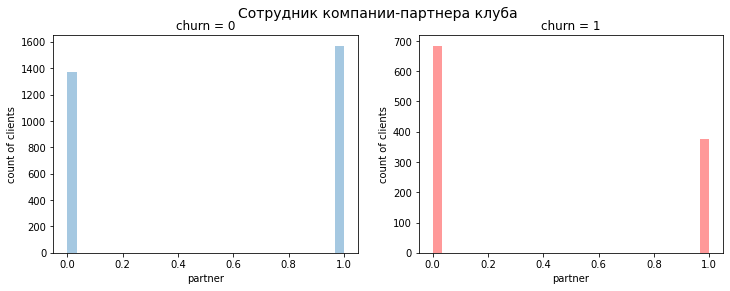

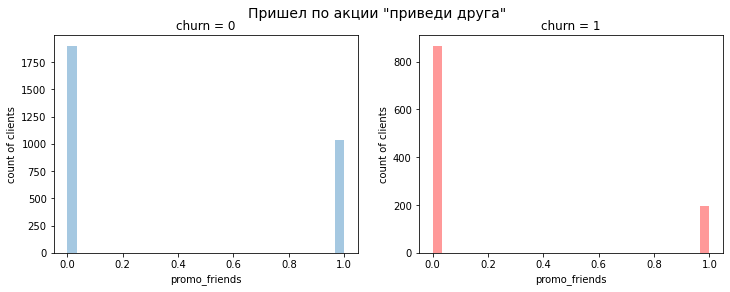

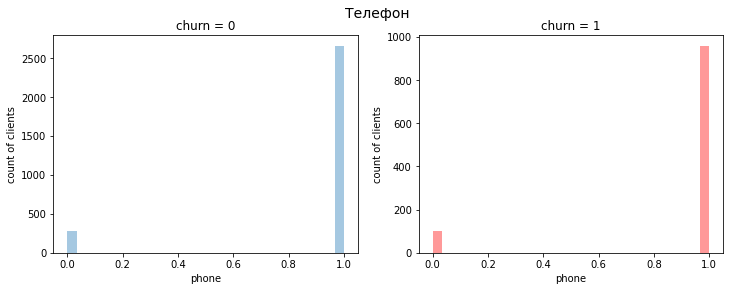

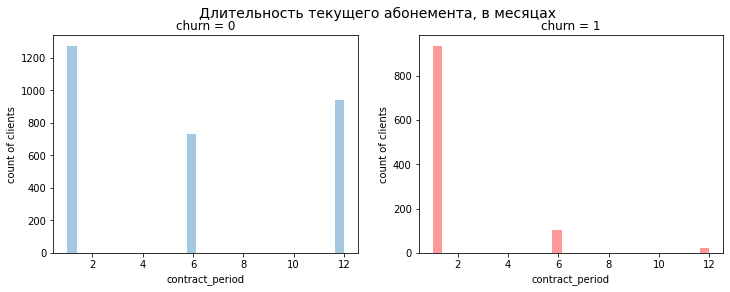

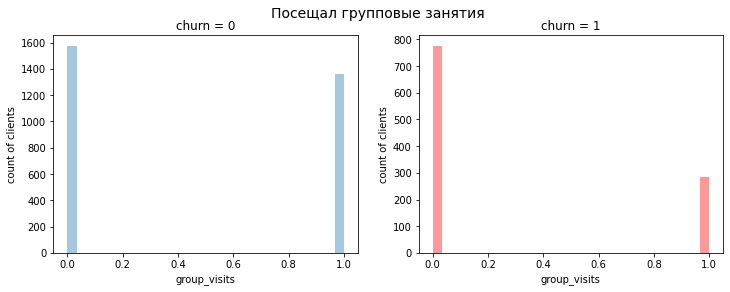

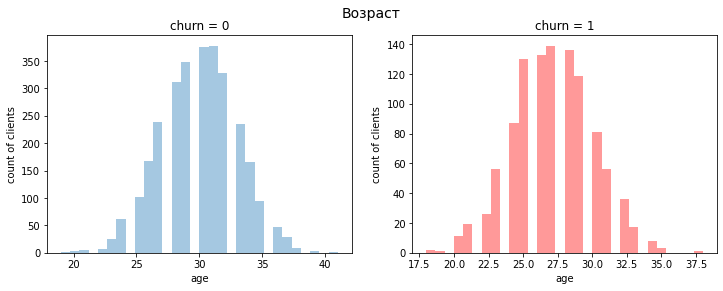

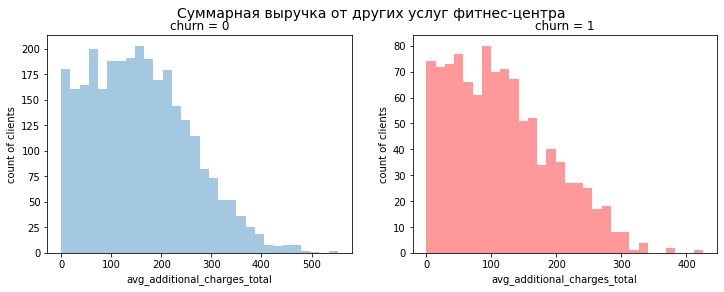

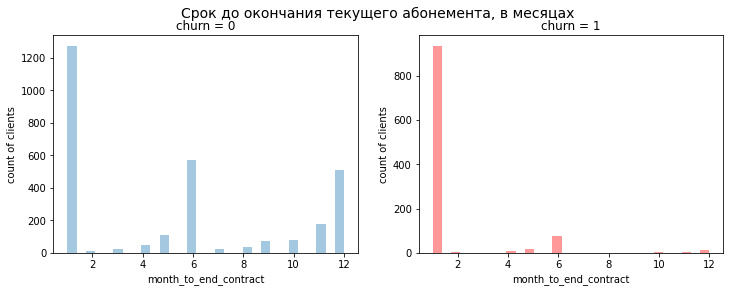

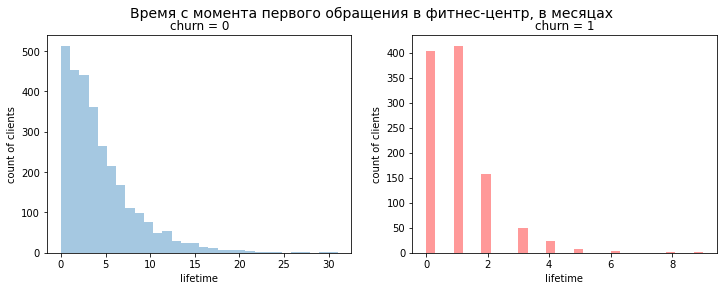

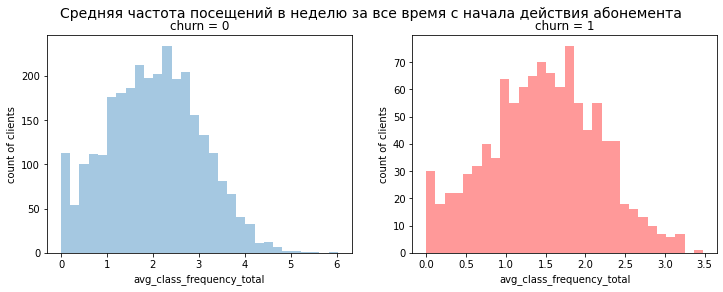

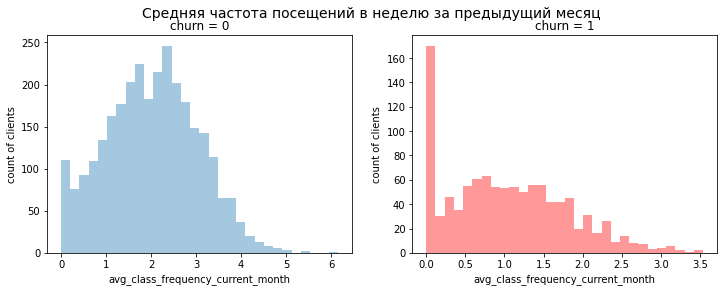

In [12]:
for argument in argument_eng: 
    fig, ax = plt.subplots(1,2,figsize=(12, 4))
    
    title = argument_name.query('name == @argument').iloc[0]['rus_name']
    #CODE REVIEW
    # тут получение имени выглядело бы так
    # про методы словарей https://pythonworld.ru/tipy-dannyx-v-python/slovari-dict-funkcii-i-metody-slovarej.html
    # title = d_feature_mapping.get(argument).get("name")

    sns.distplot(gym_df.query('churn == 0')[argument], ax=ax[0], bins=30, kde=False, label='churn = 0').set(
        title='churn = 0', xlabel=argument, ylabel='count of clients')
    sns.distplot(gym_df.query('churn == 1')[argument], ax=ax[1], bins=30, kde=False, color='r', label='churn = 1').set(
        title='churn = 1', xlabel=argument, ylabel='count of clients')
    
    plt.suptitle(title, fontsize=14)
    plt.show()

<div style="border:solid black 1px; padding: 20px">

**Вывод по графикам:**
- среди клиентов сети практически равное распределение по половой принадлежности
- клиенты фитнес-центров работающие или проживающие рядом с ним менее склонны к оттоку
- клиенты, посещающие клуб по скидке партнера менее склонны к оттоку
- клиенты, пришедшие в рамках акции "Приведи друга" менее склонны к оттоку
- предосталение контактного телефона клиента никак не влияет на отток
- клиенты, приобретающие абонемент на 1 месяц более склонны к оттоку
- клиенты, посещающие групповые занятия менее склонны к оттоку
- наблюдается, что чем старше клиент, тем менее он склонен к оттоку, хотя разница в восрасте не значительная. Клиенты в районе 30 лет менее склонны к оттоку, чем клиенты в районе 27,5 лет
- наибольшую выручки приносят стабильные клиенты, то есть можно сказать, что чем больше клиент тратит на дополнительные услуги клуба, тем меньше он склонен к оттоку 
- если у клиента заканчивается срок действия абонемента менее чем через месяц, он более склонен к оттоку
- более склонны к оттоку клиенты, посещающие фитнес-центр всего 1-2 месяца
- чем реже клиент посещает фитнес-клуб, тем больше он слонен к оттоку

---

**Важное наблюдение** - показатели `avg_class_frequency_total` и `avg_class_frequency_current_month`  фактически несут одну и ту же информацию. Это нужно учесть на этапе обучения модели.

### Построение матрицы корреляции

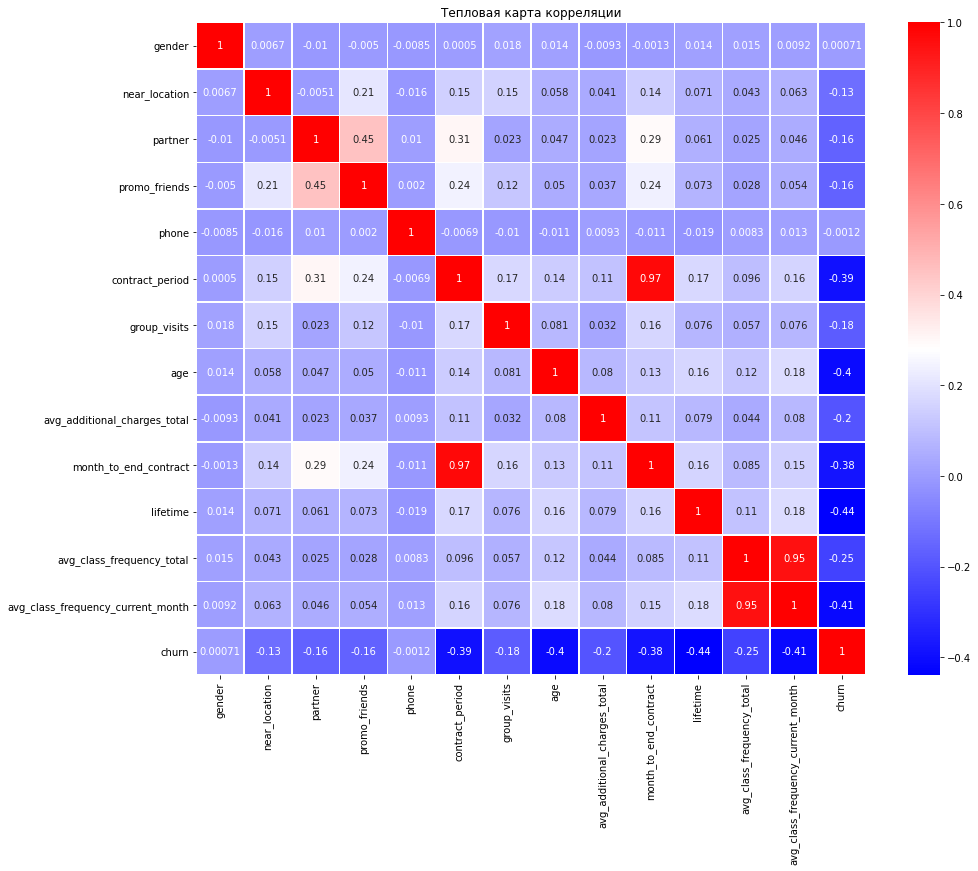

In [13]:
corr = gym_df.corr() 
plt.figure(figsize = (15,12))
sns.heatmap(corr, annot=True, cmap= 'bwr', linewidths=0.5, linecolor='white')
            
plt.title('Тепловая карта корреляции')
plt.show()

<div style="border:solid black 1px; padding: 20px">

**Выводы по матрице корреляции**

- В матрице содержатся отлицательные значения, что говорит об обратной корреляции, а именно, на примере параметра оттока:
    >- чем выше возраст, тем ниже вероятность оттока - age(-0.40)
    >- чем выше срок действия абонемента, тем ниже вероятность оттока - contract period(-0.39)
    >- чем больше срок до окончания абонемента, тем ниже вероятность, что клиент уйдет - month_to_end_contract(-0.38)
    >- чем больше времени прошло с момента первого посещения, тем ниже вероятность, что клиент уйдет - lifetime (-0.44)
    >- чем чаще клиент посещает клуб, тем ниже вероятность, что он уйдет - avg_class_frequency_total (-0.25) и avg_class_frequency_current_month (-0.44)

_Сразу стоит отметить, что все перечисленные зависимости, уже были мною озвучены по ходу исследования, и данная матрица только подтвердила предположения_

- Как и было отмечено мною ранее, очень всокая корреляция между avg_class_frequency_total и avg_class_frequency_current_month - 0,95
- Также очень коррелируются month_to_end_contract и contract_period - 0,97 - это логично - чем выше срок действия абонемента, тем дольше времени до его окончания

## Модель прогнозирования оттока клиентов

На данном этапе я буду выполнять задачу построения модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

чтобы избежать переобучения модели избавлюсь от признака, который не несет в себе полезной информации - `avg_class_frequency_current_month` - признак фактически повторяет  информацию из параметра `avg_class_frequency_total`. 

In [14]:
# чтобы избежать переобучения можели избавлюсь от признака, который не несет в себе полезной информации
gym_df = gym_df.drop('avg_class_frequency_current_month', axis = 1)
gym_df.head().T

,0,1,2,3,4
gender,1.00,0.00,0.00,0.00,1.00
near_location,1.00,1.00,1.00,1.00,1.00
partner,1.00,0.00,1.00,1.00,1.00
promo_friends,1.00,0.00,0.00,1.00,1.00
phone,0.00,1.00,1.00,1.00,1.00
contract_period,6.00,12.00,1.00,12.00,1.00
group_visits,1.00,1.00,0.00,1.00,0.00
age,29.00,31.00,28.00,33.00,26.00
avg_additional_charges_total,14.23,113.20,129.45,62.67,198.36
month_to_end_contract,5.00,12.00,1.00,12.00,1.00


От "лишниго" признака  избавилась. Отлично! Иду дальше.

In [15]:
# проведу разделение данных на признаки (матрица Х) и целевую переменную (y)
X = gym_df.drop('churn', axis = 1)
y = gym_df['churn']

Проведу баланс классов для целевой переменной оттока клиентов для оценки их сбалансированности.

In [16]:
y.value_counts()
display('Соотношение классов:', y.value_counts())

'Соотношение классов:'

0    2939
1    1061
Name: churn, dtype: int64

<div style="border:solid black 1px; padding: 20px">
    
**Наблюдение**
    
Данные не сбалансированы, что ожедаемо. Речь идет о клиентах фитнес-центра, где посещаемость зависит от огромного чиста параментров (даже таких, как приближющися пляжный сезон). Мне не известно за какой период данны данные, поэтому стоит принять как данность, что соотношения 50/50 не будет, в связи с чем перебалансировку выполнять не нужно.

In [17]:
X.head(1).T

,0
gender,1.00
near_location,1.00
partner,1.00
promo_friends,1.00
phone,0.00
contract_period,6.00
group_visits,1.00
age,29.00
avg_additional_charges_total,14.23
month_to_end_contract,5.00


In [18]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

### Обучение по методу логистической регрессией

In [19]:
# далее провожу разделение модели на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [20]:
# задаю алгоритм для нашей модели

model = LogisticRegression(solver='liblinear')

# обучаю модель

model.fit(X_train, y_train)

# делаю прогнозы

predictions_lg = model.predict(X_test)

In [21]:
# вывожу все метрики
display('Обучение по методу логистической регрессией. Основные метрики')
display('Accuracy | Нет баланса классов: {:.2f}'.format(accuracy_score(y_test, predictions_lg)))
display('Precision: {:.2f}'.format(precision_score(y_test, predictions_lg)))
display('Recall: {:.2f}'.format(recall_score(y_test, predictions_lg)))
display('F1: {:.2f}'.format(f1_score(y_test, predictions_lg)))

'Обучение по методу логистической регрессией. Основные метрики'

'Accuracy | Нет баланса классов: 0.90'

'Precision: 0.82'

'Recall: 0.81'

'F1: 0.81'

### Обучение по методу случайного леса

In [22]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса

rf_model.fit(X_train, y_train)

# сделать прогнозы

rf_predictions = rf_model.predict(X_test) # Ваш код здесь

In [23]:
# выведем все метрики

display('Обучение по методу случайного леса. Основные метрики')
display('Accuracy | Нет баланса классов: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
display('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
display('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
display('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

'Обучение по методу случайного леса. Основные метрики'

'Accuracy | Нет баланса классов: 0.90'

'Precision: 0.82'

'Recall: 0.78'

'F1: 0.80'

**Выводы**

-  Модель логической регресси показала себя лучше по показателям Recall и F1, хотя различие нельзя назвать значительным.

## Кластеризация признаков
### Стандартизация данных

In [24]:
# создаю объект класса StandardScaler и применим его к обучающей выборке

scaler = StandardScaler()

# обучаю scaler и одновременно трансформируем матрицу для обучающей выборки

X_st = scaler.fit_transform(X)  

# обязательная стандартизация данных перед работой с алгоритмами

linked = linkage(X_st, method = 'ward')

### Построение матрицы расстояний функцией linkage()

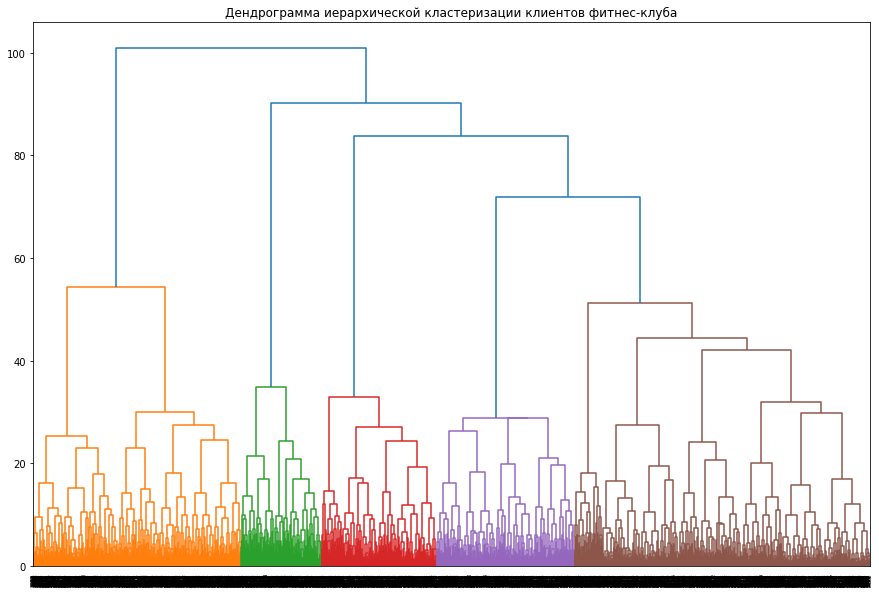

In [25]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархической кластеризации клиентов фитнес-клуба')
plt.show() 

Дендограмма иерархической кластеризации клиентов фитнес-клуба выделила 5 кластеров.

### Обучение модели кластеризации на основании алгоритма K-Means и прогнозирование кластеров клиентов

In [26]:
# задаю число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата

km = KMeans(n_clusters=5, random_state=0) 

# применяем алгоритм к данным и формируем вектор кластеров

labels = km.fit_predict(X_st)

# сохраняем метки кластера в поле нашего датасета

gym_df['cluster_number'] = labels

### Изучение средних значения признаков для кластеров

In [27]:
# изучу средние значения признаков для каждого из 5 кластеров
claster_mean = gym_df.groupby('cluster_number').mean().T
claster_mean

cluster_number,0,1,2,3,4
gender,0.50,0.51,0.52,0.50,0.52
near_location,0.95,1.00,1.00,0.00,0.86
partner,0.74,0.77,0.23,0.47,0.47
promo_friends,0.47,1.00,0.00,0.08,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,11.67,3.05,2.09,2.37,4.78
group_visits,0.55,0.46,0.38,0.22,0.43
age,30.00,29.13,28.91,28.59,29.30
avg_additional_charges_total,166.35,142.74,141.77,136.39,144.21
month_to_end_contract,10.62,2.84,1.99,2.21,4.47


Ключевой - параметр near_location (проживание или работа в районе, где находится фитнес-центр).

### Построение распределений признаков для кажого из кластеров

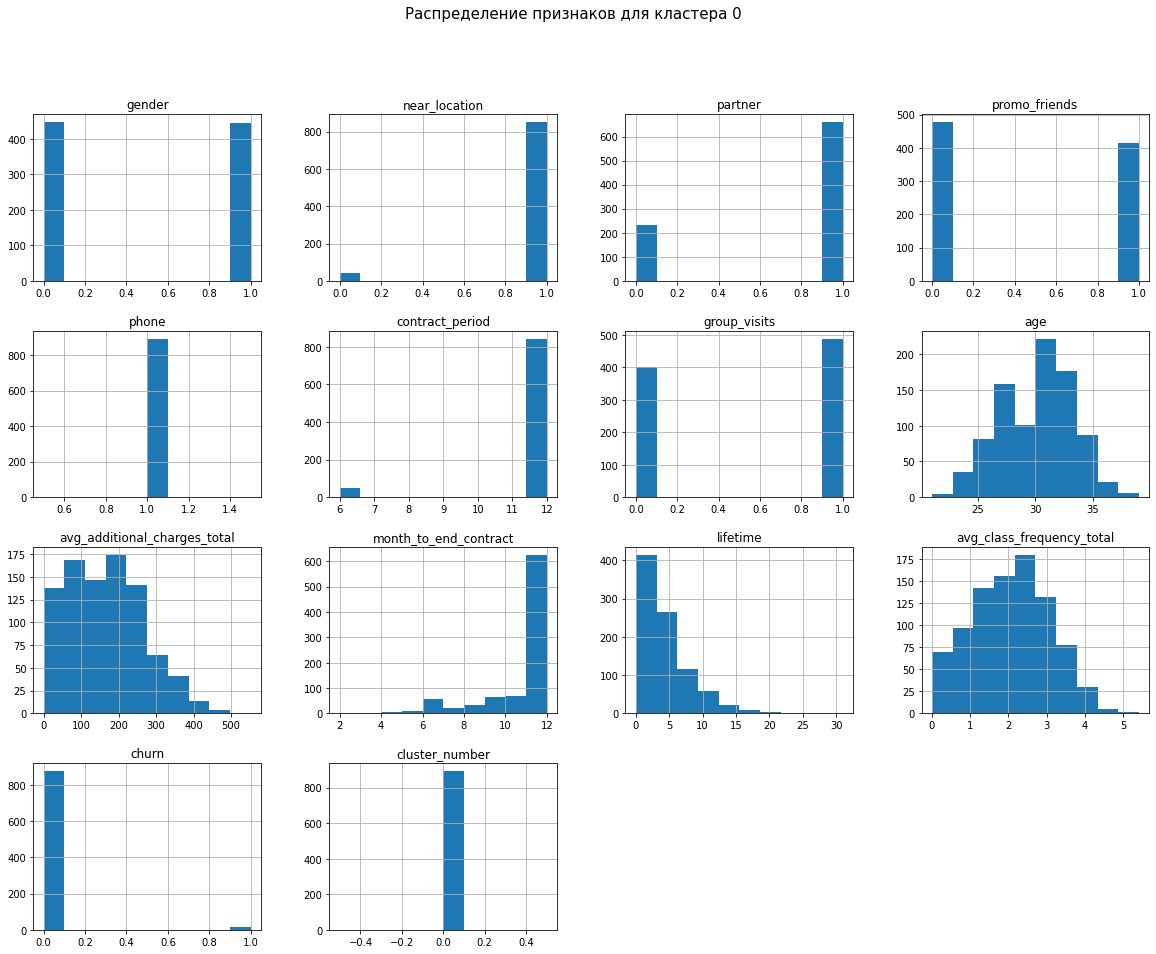

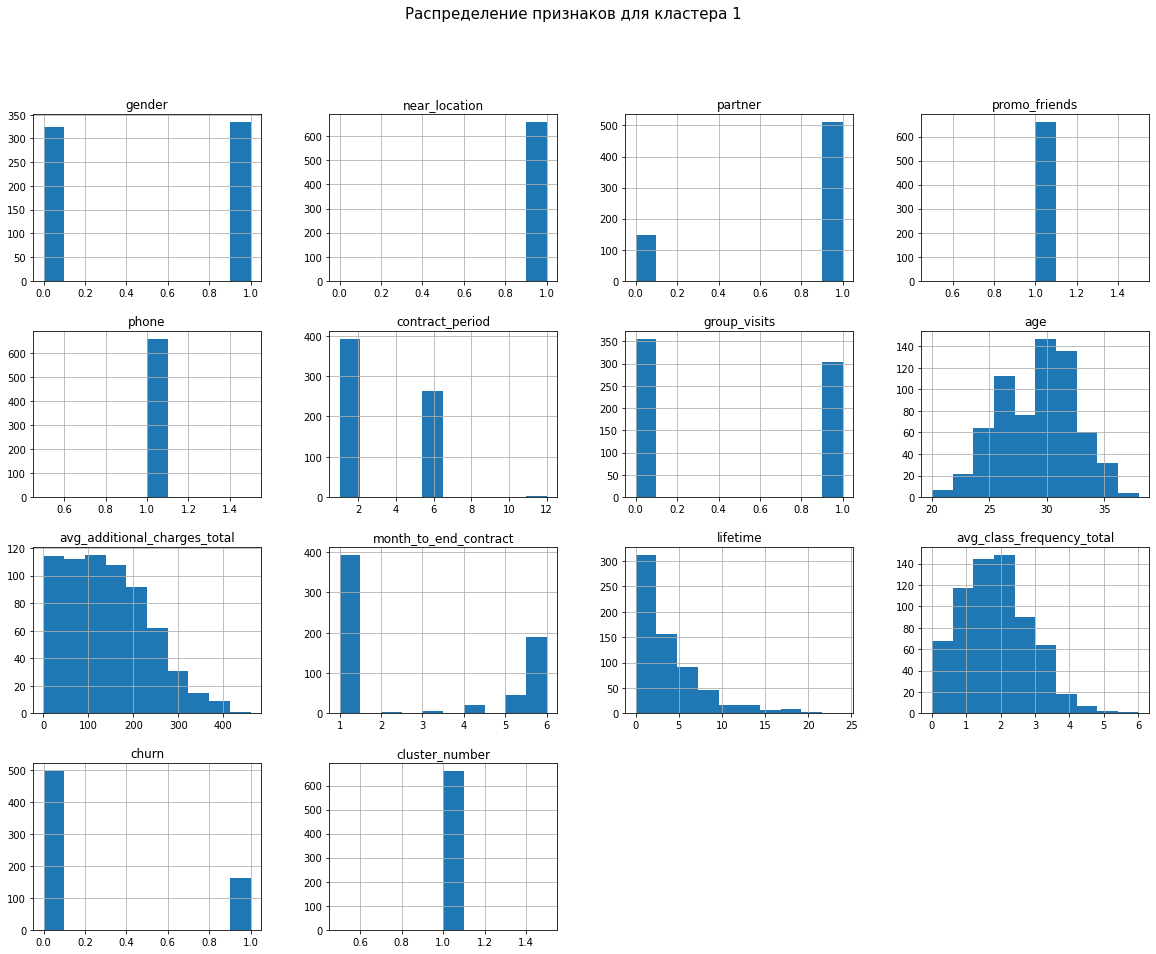

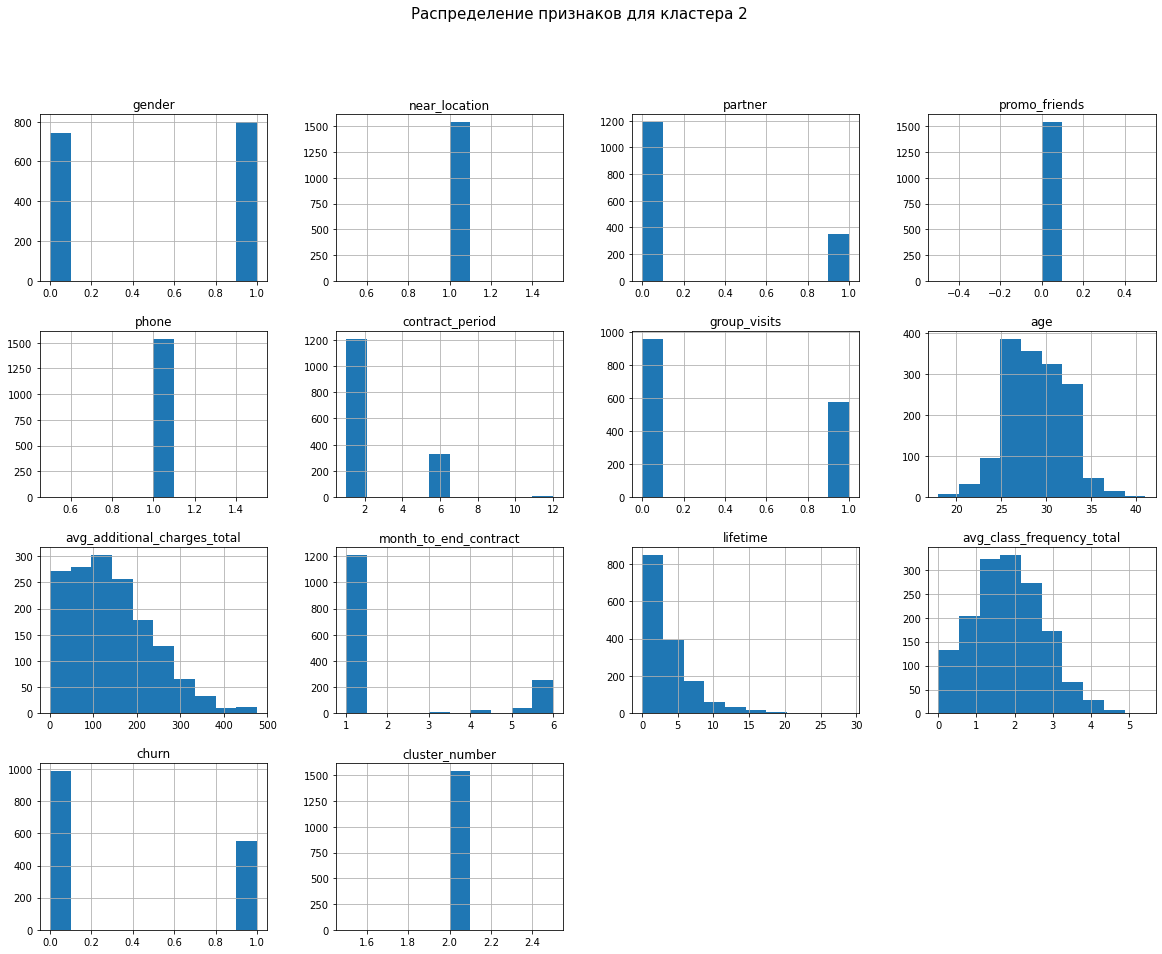

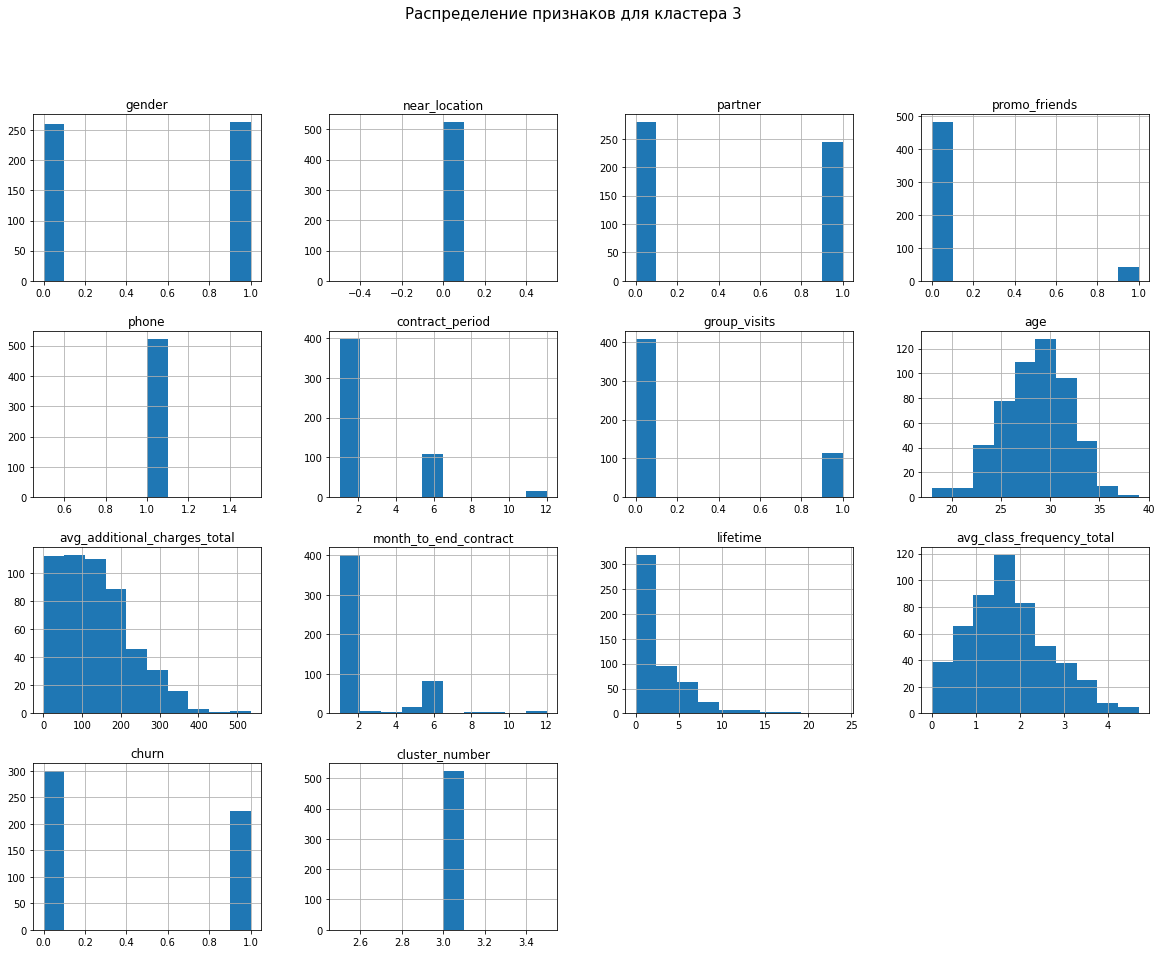

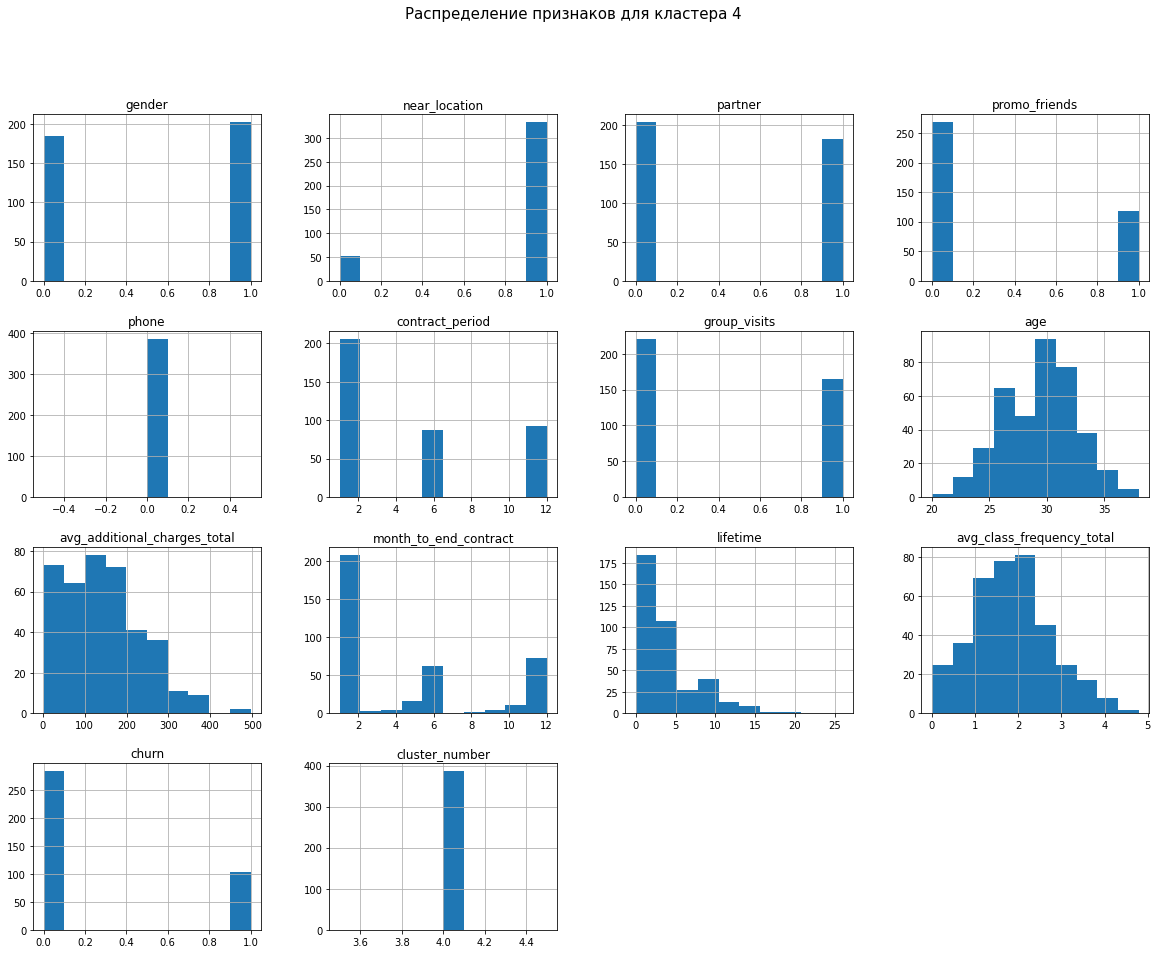

In [28]:
for value in [0, 1, 2, 3, 4]:
    gym_df[gym_df['cluster_number']==value].hist(figsize=(20,15))
    plt.suptitle('Распределение признаков для кластера {}'.format(value), fontsize = 15)
    plt.show()

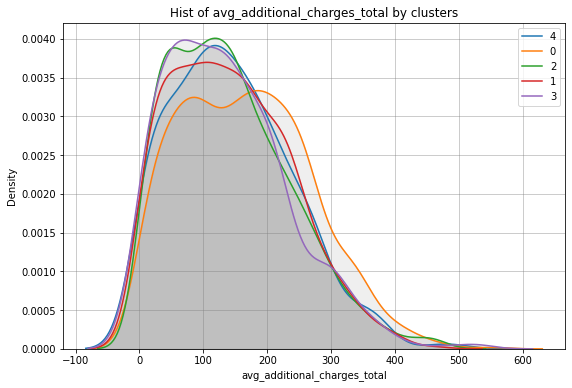

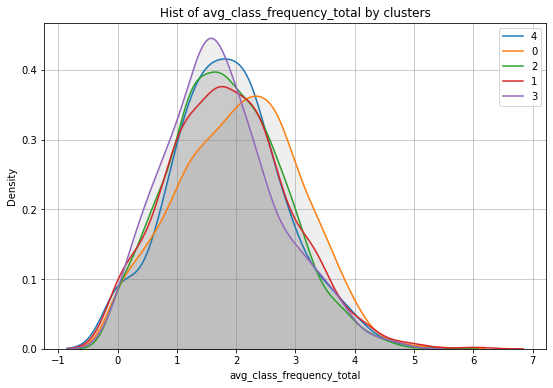

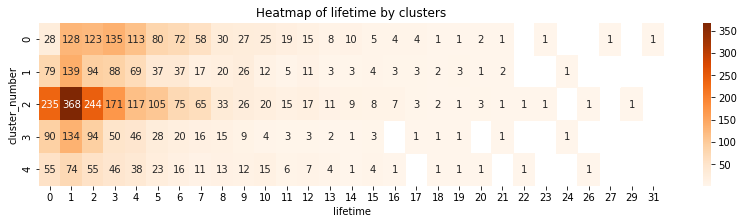

In [29]:
d_feature_category = {
    'binary': ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Phone'],
    'discrete': ['lifetime'],
    'continuos': ['avg_additional_charges_total', 'avg_class_frequency_total']
}

# continuous
for col in d_feature_category['continuos']:
    fig, ax = plt.subplots(figsize=(9, 6))
    for cl in gym_df['cluster_number'].unique():
        # кривая
        sns.kdeplot(gym_df.query("cluster_number==@cl")[col], ax=ax, label=cl)
        #  заполнение
        x = ax.lines[-1].get_xdata()
        y = ax.lines[-1].get_ydata()
        ax.fill_between(x, 0, y, color='grey', alpha=0.125)
    ax.legend()
    ax.set_title(f'Hist of {col} by clusters')
    ax.grid(color='grey', alpha=0.5);

    
#discrete
for col in d_feature_category['discrete']:
    fig, ax = plt.subplots(figsize=(14, 3))
    viz_data = gym_df.reset_index()\
                .pivot_table(
                    index='cluster_number',
                    columns=col,
                    values='index',
                    aggfunc='count'
                    )
    sns.heatmap(viz_data, cmap='Oranges', annot=True, fmt='.0f', ax=ax)
    ax.set_title(f'Heatmap of {col} by clusters')
    ax.grid(False)
    plt.show();

<div style="border:solid black 1px; padding: 20px">

**Интересные наблюдения**

***Кластер 1***
- равномерное распределение полов среди клиентов
- клиенты живут или работаю рядом с фитнес-центром
- большенство клиентов по посещают клуб по партнерской программе
- примерно одинаковое число клиентов "привел друг" и "пришли сами"
- все клиенты оставили контактный телефон
- почти у всех клиентов абонемент на 12 месяцев
- примерно одиаковое число клиентов как ходит на групповые программы так и нет
- средний возраст клиента кластера - 30 лет
- клиенты кластера фактически не попадают в отток - **_самый высокий показатель среди всех кластеров_**
- в среднем посещают клуб 2-3 раза в неделю

В общем и целом клиенты кластера - молодцы!:)


***Кластер 2***
- равномерное распределение полов среди клиентов
- клиенты живут или работаю рядом с фитнес-центром
- большенство клиентов по посещают клуб по партнерской программе
- все клиенты пришли по акции "Приведи друга"
- все клиенты оставили контактный телефон
- клиенты приобретают абонементы на 1 и 6 месяцев
- примерно одиаковое число клиентов как ходит на групповые программы так и нет
- средний возраст клиентов - 30 лет
- посещают центр примерно 2 раза в неделю
- клиенты редко попадают в отток


***Кластер 3***
- равномерное распределение полов среди клиентов
- клиенты живут или работаю рядом с фитнес-центром
- большенство клиентов по посещают клуб по партнерской программе
- никого из клиентов не привел друг
- все клиенты оставили телефон
- клиенты чаще не ходят на групповые занятия, чем ходят
- средний возраст клиентов кластера - 25 лет
- клиенты реже попадают в отток, чем остаются - **_самый высокий показатель оттока во всех кластерах_**


***Кластер 4***
- равномерное распределение полов среди клиентов
- клиенты не живут и не работают рядом с фитнес-центом
- половина клиентов имеет скидку партнера
- большенство клиентов не принимало участие в акции "Приведи друга"
- клиенты оставили контактный телефок
- большенство клиентов не посещает групповые занятия
- средний возраст 30 лет
- чаще покупают абонемент на 1 месяц
- ходят 1 раз в неделю
- примерно в равной доле остаются и попадают в отток


***Кластер 4***
- почти что равномерное распределение полов среди клиентов
- большенство клиентов раотают или живут рядом с фитнес-центром
- примерно половина клиентов является сотрудником партнера клуба
- меньшую часть клиентов привели друзья
- клиенты не оставили свой контактный номер
- чаще клиенты покупают абонемент на 1 месяц, на 6 и на 12 месяцев купили примерно одинаковое число клиентов
- большая часть клиентов не посещает групповые занятия
- средний возраст 30 лет
- посещают примерно 2 раза в неделю
- меньшая часть клиентов кластера попадает в отток

### Расчет доли оттока

In [30]:
gym_df.head().T

,0,1,2,3,4
gender,1.00,0.00,0.00,0.00,1.00
near_location,1.00,1.00,1.00,1.00,1.00
partner,1.00,0.00,1.00,1.00,1.00
promo_friends,1.00,0.00,0.00,1.00,1.00
phone,0.00,1.00,1.00,1.00,1.00
contract_period,6.00,12.00,1.00,12.00,1.00
group_visits,1.00,1.00,0.00,1.00,0.00
age,29.00,31.00,28.00,33.00,26.00
avg_additional_charges_total,14.23,113.20,129.45,62.67,198.36
month_to_end_contract,5.00,12.00,1.00,12.00,1.00


In [31]:
# создам сгруппированную таблицу churn_part

churn_part = gym_df.groupby('cluster_number')['churn'].agg({'mean', 'sum', 'count'}).reset_index()
churn_part.columns = ['cluster_number', 'mean', 'sum', 'count']
churn_part

,cluster_number,mean,sum,count
0,0,892,18,0.02
1,1,659,163,0.25
2,2,1540,553,0.36
3,3,523,224,0.43
4,4,386,103,0.27


In [32]:
# расчитаем долю оттока для каждого кластера

for col in range(len(churn_part)):
    i = np.round(churn_part.iat[col,1]*100, 2)
    print('Доля оттока для', col, 'кластера равна', i, '%')

Доля оттока для 0 кластера равна 89200 %
Доля оттока для 1 кластера равна 65900 %
Доля оттока для 2 кластера равна 154000 %
Доля оттока для 3 кластера равна 52300 %
Доля оттока для 4 кластера равна 38600 %


<div style="border:solid black 1px; padding: 20px">

**Вывод**

_Наблюдения_
>- Самая высокая доля оттока у 4 (индекс 3) кластера - 42.83 %
>- Самая низкая доля оттока у 1 (индекс 0) кластера - всего 2.02 %

Исходя из этой информации, а так же базируясь на выполненном анализе, можно сделать следующие выводы:

Скорее всего клиент попадет в отток если:
- Не живет и не работает рядом с фитнес-центром
- Не посещает групповые занятия
- Купил абонемент сроком на 1 месяц
- Пришел вне акции "Приведи друга"
- Имеет низкую частоту посещения

Скорее всего клиент продлит посещение фитнес-центра если:
- Живет или работает рядом с фитнес-центром
- Посещает центр в рамках партнерской программы
- Приобрел абонемент на долгий срок, такой как 12 месяцев
- Посещает центр примерно 2-3 раза в неделю
- Пришел в рамках акции "Приведи друга", то есть посещает центр в компании
- Посещает групповые программы


## Общие выводы

<div style="border:solid green 3px; padding: 20px">


**Рекомендация для бизнеса**

- Клиенты благотворно отвечают посещением на скидки поэтому:
>- Если клиент не живет и не работает рядом с центром, стоит предложить ему скидку на пролонгацию абонемента
>- Предложить партнерские проргаммы организациям по близости к ТЦ, как для сотрудников, так и для клиентов
>- Сохранить в фитнес-центрах программу "Приведи друга", клиенты охотно посещают центр в компании
- Клиенты, пользующиеся дополнительными услугами центра, охотнее остаются, поэтому стоит предлагать бесплатное пробное посещение например на массаж или в косметический салон
- Клиенты, посещающие групповые программы охотнее остаются, возможно стоит ввести акцию "Пробное посещение группового занятия" перед приобретением абонемента для новых клиентов
- Ниже отток у клиентов с долгосрочными абонементами, поэтому стоит постараться сделать приобретение этих абонементов для клиентов наиболее выгодными. Отдел продаж должен стараться реализовать именно их
- Если наблюдается снижение частоты посещений, предусмотреть "возврат" клиента за счет акций и предложений, наприемер "Тренировка в подарок"